# Train a very simple model

In [1]:
DATA_TRAIN_PATH = 'data/train'
DATA_TEST_PATH = 'data/test'
LABELS_TRAIN_PATH = 'data/labels_10k.csv'
LABELS_TEST_PATH = 'data/labels_test.csv'

In [5]:
import pandas as pd
import numpy as np
import os

### Load data from disk

In [7]:
df_labels_train = pd.read_csv(LABELS_TRAIN_PATH)
df_labels_test = pd.read_csv(LABELS_TEST_PATH)
print(df_labels_train)

      Unnamed: 0  label
0              0      5
1              1      0
2              2      4
3              3      1
4              4      9
...          ...    ...
9995        9995      5
9996        9996      8
9997        9997      6
9998        9998      9
9999        9999      7

[10000 rows x 2 columns]


In [11]:
def load_data(df_labels, dirpath):
    data = []
    for i, row in df_labels.iterrows():
        loadpath = os.path.join(dirpath, f'{i}.npy')
        img = np.load(loadpath)
        data.append(img)
    return np.array(data)

data_train = load_data(df_labels_train, DATA_TRAIN_PATH)
data_test = load_data(df_labels_test, DATA_TEST_PATH)

In [13]:
print(data_train.shape, data_test.shape)

(10000, 28, 28) (10000, 28, 28)


### Make a train/val split

In [23]:
from sklearn.model_selection import train_test_split

labels_train_array = labels_train['label'].values

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(data_train, labels_train_array, test_size=0.2, random_state=42)

# Print the shapes of the resulting sets
print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)

Training set shape: (8000, 28, 28)
Validation set shape: (2000, 28, 28)


### Look at a few examples

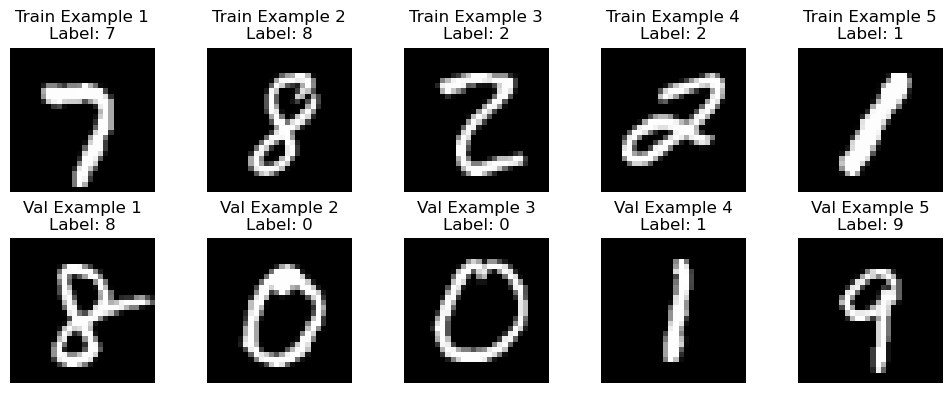

In [24]:
import matplotlib.pyplot as plt

# Define the number of random examples to display
num_examples = 5

# Randomly select examples and corresponding labels from the training set
train_indices = np.random.choice(len(X_train), num_examples, replace=False)
train_examples = X_train[train_indices]
train_labels = y_train[train_indices]

# Randomly select examples and corresponding labels from the validation set
val_indices = np.random.choice(len(X_val), num_examples, replace=False)
val_examples = X_val[val_indices]
val_labels = y_val[val_indices]

# Plot the random examples from the training set
plt.figure(figsize=(10, 4))
for i in range(num_examples):
    plt.subplot(2, num_examples, i + 1)
    plt.imshow(train_examples[i], cmap='gray')
    plt.axis('off')
    plt.title('Train Example {}\nLabel: {}'.format(i + 1, train_labels[i]))

# Plot the random examples from the validation set
for i in range(num_examples):
    plt.subplot(2, num_examples, num_examples + i + 1)
    plt.imshow(val_examples[i], cmap='gray')
    plt.axis('off')
    plt.title('Val Example {}\nLabel: {}'.format(i + 1, val_labels[i]))

plt.tight_layout()
plt.show()


### Get the data ready for pytorch

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train).float()
X_val_tensor = torch.from_numpy(X_val).float()
y_train_tensor = torch.from_numpy(y_train)
y_val_tensor = torch.from_numpy(y_val)

# Create DataLoader for training and validation sets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

### Define a model and training approach

In [28]:
# Define logistic regression model
class LogisticRegression(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, x):
        out = self.linear(x)
        return out

In [29]:
# Initialize model, loss function, and optimizer
input_size = 28 * 28  # Assuming images are 28x28 pixels
num_classes = 10  # Assuming 10 classes (e.g., digits 0-9)
model = LogisticRegression(input_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

### Run training

In [33]:
# Print initial loss and accuracy
model.eval()
with torch.no_grad():
    total_correct = 0
    total_samples = 0
    total_loss = 0.0
    for inputs, labels in val_loader:
        inputs = inputs.view(-1, input_size)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

    initial_accuracy = total_correct / total_samples
    initial_loss = total_loss / len(val_loader)
    print(f'Initial Loss: {initial_loss:.4f}, Initial Accuracy: {initial_accuracy:.4f}')

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        inputs = inputs.view(-1, input_size)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation loop
    model.eval()
    with torch.no_grad():
        total_correct = 0
        total_samples = 0
        total_loss = 0.0
        for inputs, labels in val_loader:
            inputs = inputs.view(-1, input_size)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

        accuracy = total_correct / total_samples
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(val_loader):.4f}, Accuracy: {accuracy:.4f}')


Initial Loss: 161.9934, Initial Accuracy: 0.8905
Epoch [1/50], Loss: 191.4065, Accuracy: 0.8745
Epoch [2/50], Loss: 149.1341, Accuracy: 0.9080
Epoch [3/50], Loss: 149.8011, Accuracy: 0.9035
Epoch [4/50], Loss: 160.6976, Accuracy: 0.8970
Epoch [5/50], Loss: 153.1508, Accuracy: 0.8960
Epoch [6/50], Loss: 155.8469, Accuracy: 0.9010
Epoch [7/50], Loss: 343.6019, Accuracy: 0.8085
Epoch [8/50], Loss: 175.8249, Accuracy: 0.8885
Epoch [9/50], Loss: 168.4834, Accuracy: 0.8915
Epoch [10/50], Loss: 159.8853, Accuracy: 0.8970
Epoch [11/50], Loss: 150.0447, Accuracy: 0.9020
Epoch [12/50], Loss: 204.5606, Accuracy: 0.8720
Epoch [13/50], Loss: 174.4497, Accuracy: 0.8900
Epoch [14/50], Loss: 193.1221, Accuracy: 0.8855
Epoch [15/50], Loss: 192.4699, Accuracy: 0.8710
Epoch [16/50], Loss: 187.4526, Accuracy: 0.8825
Epoch [17/50], Loss: 165.6248, Accuracy: 0.8975
Epoch [18/50], Loss: 167.4751, Accuracy: 0.8940
Epoch [19/50], Loss: 155.9328, Accuracy: 0.9050
Epoch [20/50], Loss: 174.7864, Accuracy: 0.8820


### Save the model for later use

In [34]:
model_path = 'models/logistic_regression_model.pth'

# Save the model's state dictionary and other information
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'input_size': input_size,
    'num_classes': num_classes,
}, model_path)

print("Model saved successfully at:", model_path)


Model saved successfully at: models/logistic_regression_model.pth
